In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


In [3]:
Train_DIR = ".\Brain_Tumor_Dataset\Training"
number_of_images  = {}

In [4]:
# ROOT_DIR = ".\Brain_Tumor_Dataset"


for category in os.listdir(Train_DIR):
    category_path = os.path.join(Train_DIR, category)
    if os.path.isdir(category_path):
        number_of_images[category] = len(os.listdir(category_path))

print(number_of_images.items())


dict_items([('glioma', 1321), ('meningioma', 1339), ('notumor', 1595), ('pituitary', 1457)])


In [5]:
train_path = []
train_lable = []

for label in os.listdir(Train_DIR):
    for img in os.listdir(os.path.join(Train_DIR, label)):
        train_path.append(os.path.join(Train_DIR, label,img))
        train_lable.append(label)


train_path, train_lable = shuffle(train_path, train_lable)


In [6]:
train_path

['.\\Brain_Tumor_Dataset\\Training\\glioma\\Tr-gl_0878.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\meningioma\\Tr-me_0713.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\pituitary\\Tr-pi_0062.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_1581.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0529.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0931.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0981.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_1448.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\glioma\\Tr-gl_0919.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0485.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\pituitary\\Tr-pi_1137.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0339.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\pituitary\\Tr-pi_1165.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\pituitary\\Tr-pi_1360.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\glioma\\Tr-gl_0779.jpg',
 '.\\Brain_Tumor_Dataset\\Training\\notumor\\Tr-no_0343.jpg',


In [7]:
test_path = []
test_lable = []
Test_DIR = ".\Brain_Tumor_Dataset\Testing"


for label in os.listdir(Test_DIR):
    for img in os.listdir(os.path.join(Test_DIR, label)):
        test_path.append(os.path.join(Test_DIR, label,img))
        test_lable.append(label)


test_path, test_lable = shuffle(test_path, test_lable)


In [8]:
test_path

['.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-meTr_0003.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\notumor\\Te-no_0351.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\glioma\\Te-gl_0183.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\glioma\\Te-gl_0113.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\notumor\\Te-no_0389.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\notumor\\Te-no_0261.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-me_0136.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-me_0187.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\pituitary\\Te-pi_0193.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\notumor\\Te-no_0309.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-me_0013.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\pituitary\\Te-pi_0260.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\glioma\\Te-gl_0284.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-me_0059.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\notumor\\Te-no_0214.jpg',
 '.\\Brain_Tumor_Dataset\\Testing\\meningioma\\Te-me_0144.jpg',
 '.

## Visulaization of DataSet

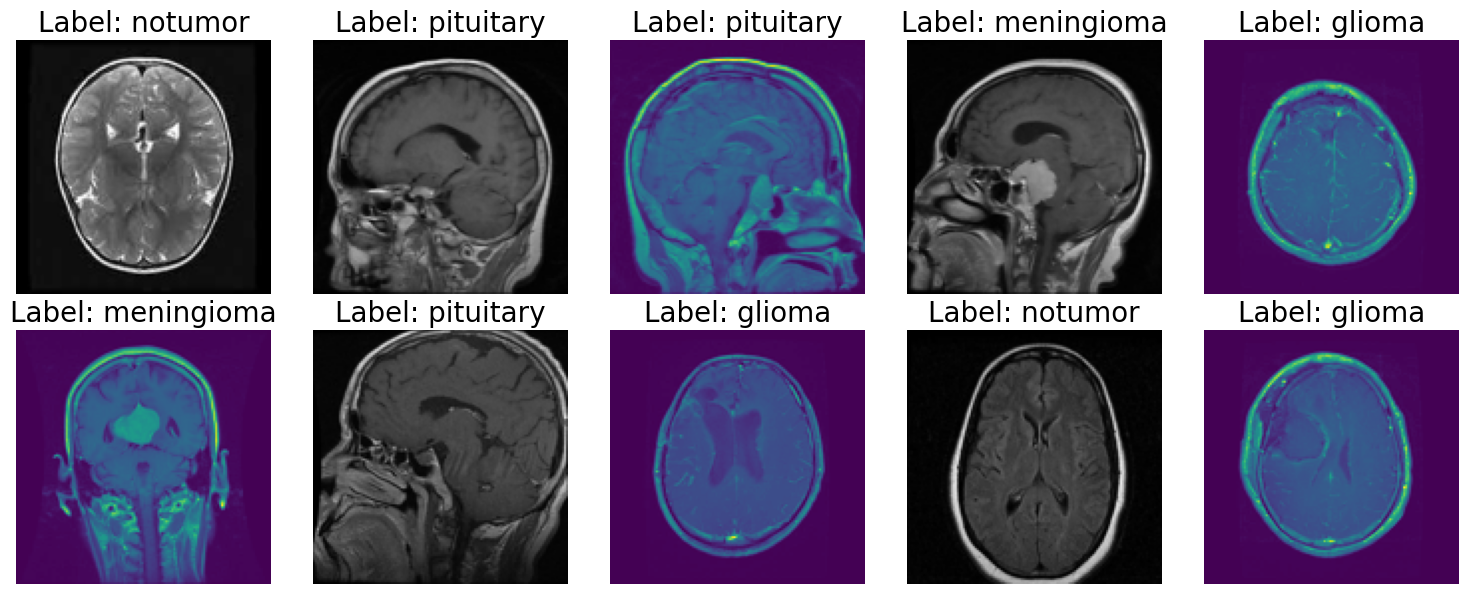

In [9]:
import random
import matplotlib.pyplot as plt

random_index = random.sample(range(len(train_path)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Loop through the random indices and display images
for i, idx in enumerate(random_index):
    img_path = train_path[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))

    # Display images
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {train_lable[idx]}", fontsize = 20)

plt.tight_layout()
plt.show()


## Function Needed for Data Preprossing

In [16]:

IMAGE_SIZE = 128


# Image AUGEMNTATION feature
def img_augemnt(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)/ 255.0
    return image

# For loading image and Applying fuction
def open_img(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_augemnt(img)
        images.append(img)
    return np.array(images)

# Encoding Labels (converting lables into integer)
def encoding_label(labels):
    unique_labels = sorted(os.listdir(Train_DIR))   # consistent ordering
    return np.array([unique_labels.index(label) for label in labels])


# For batch processing
def datagen(paths, labels, batch_size = 12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_img(batch_paths)
            batch_labels = labels[i:i+batch_size]
            batch_labels = encoding_label(batch_labels)
            yield batch_images, batch_labels



## Image Model Training

In [11]:
len(os.listdir(Train_DIR))


4

In [18]:
IMAGE_SIZE = 128

base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

for layers in base_model.layers:
    layers.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True



# Building the Model

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3)))                   # Input layer
model.add(base_model)                                                # Add Base Model(i.e VGG16) in Sequential Model
model.add(Flatten())                                                 # Add Flattener layer
model.add(Dropout(0.3))                                              # Drop some nurons so that overfitting is avoided(here 30% of neuron is droped)

model.add(Dense(128, activation='relu'))                             # Dense Layer
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(Train_DIR)), activation='softmax'))   # Final Output Layer


# Model Compilation

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])


# Specify Parameter
batch_size = 20
step = int(len(train_path) / batch_size)
epochs = 8

# Train The Model
history = model.fit(
    datagen(train_path, train_lable, batch_size = batch_size, epochs=epochs),
    epochs = epochs,
    steps_per_epoch = step
) 



Epoch 1/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 199s 693ms/step - loss: 0.4571 - sparse_categorical_accuracy: 0.8249
Epoch 2/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 219s 771ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9160
Epoch 3/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 195s 686ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9376
Epoch 4/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 195s 685ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9573
Epoch 5/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 196s 688ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9638
Epoch 6/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 195s 684ms/step - loss: 0.0716 - sparse_categorical_accuracy: 0.9736
Epoch 7/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 196s 686ms/step - loss: 0.0592 - sparse_categorical_accuracy: 0.9807
Epoch 8/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 195s 686ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9809


## Train Test Validation

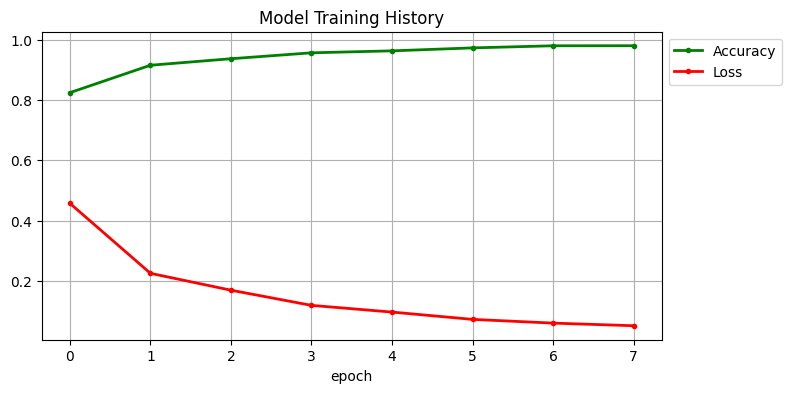

In [19]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_img(test_path)  # Load and augment test images
test_labels_encoded = encoding_label(test_lable)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 812ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       300
           1       0.90      0.95      0.93       306
           2       1.00      1.00      1.00       405
           3       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



## Confusion Matrix

Confusion Matrix:
[[269  30   0   1]
 [  5 291   1   9]
 [  0   0 405   0]
 [  0   2   0 298]]


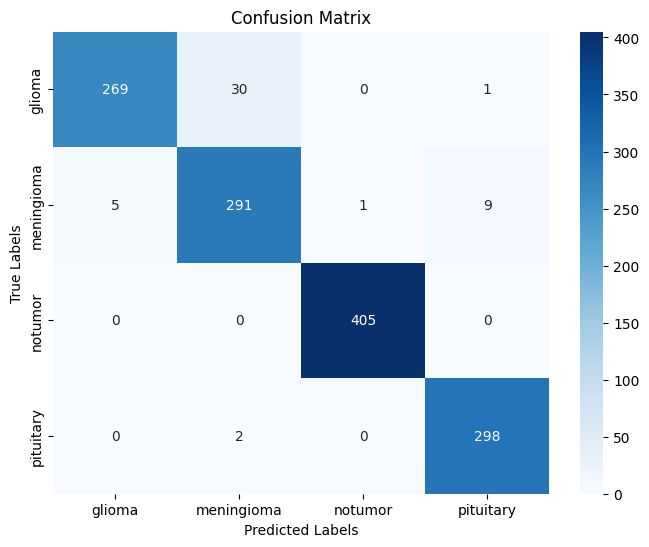

In [22]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(Train_DIR), yticklabels=os.listdir(Train_DIR))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## ROC Curve

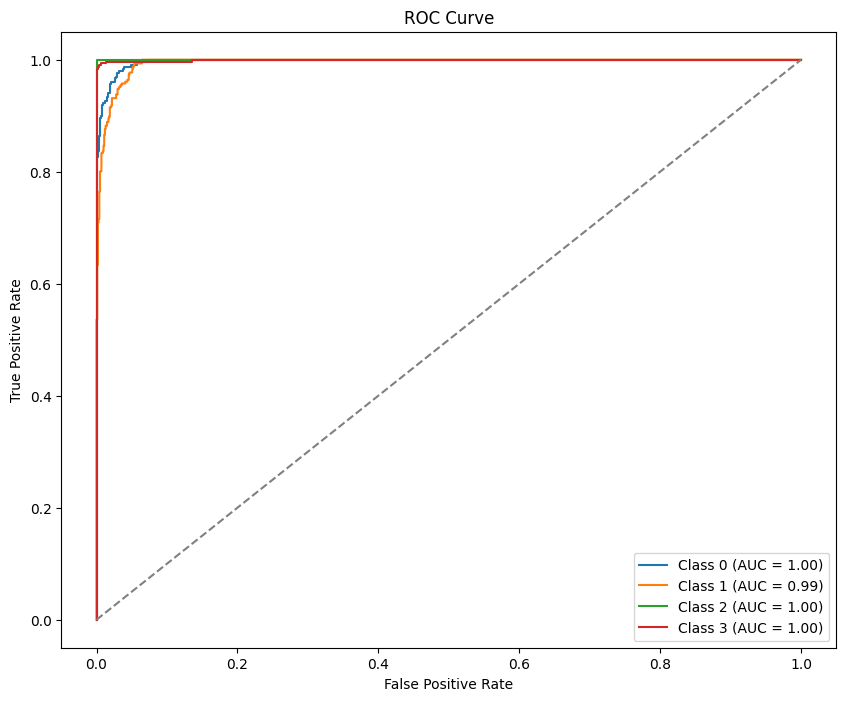

In [27]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(Train_DIR))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(Train_DIR))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(Train_DIR))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Save and Load Model

In [25]:
model.save('model.h5')

In [26]:

from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')


##  MRI Tumor Detection System

In [28]:

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Class labels
class_labels = ['glioma','meningioma', 'notumor' ,'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


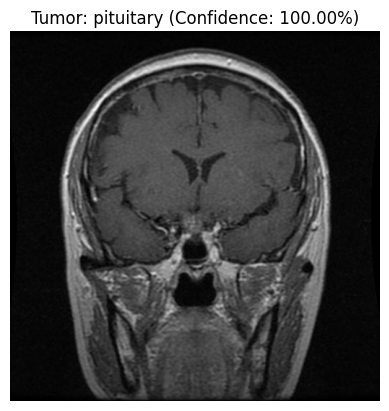

In [43]:
# Example usage
image_path = 'Brain_Tumor_Dataset\Testing\pituitary\Te-pi_0210.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)